## 6. Putting it all together

Let's go back through the steps above and see it all in one place

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu126'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

## 6.1 Data

In [5]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Split the data

In [6]:
# Create a train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [8]:
# Define the plot_predictions() function
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10, 7))

    # Plot training data
    plt.scatter(train_data, train_labels, label='Train Data', color='blue')

    # Plot test data
    plt.scatter(test_data, test_labels, label='Test Data', color='green')

    # Check if predictions is not None
    if predictions is not None:
        plt.scatter(test_data, predictions, label='Predictions', color='red')

    # Show legend
    plt.legend(prop={'size': 14})
    plt.show()

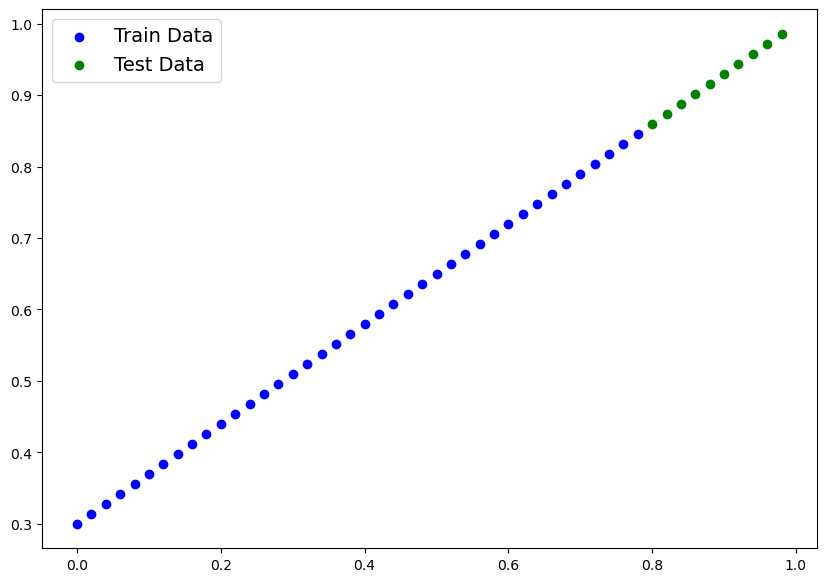

In [9]:
# Plot the data

plot_predictions(X_train,y_train,X_test,y_test)

## 6.2 Building a PyTorch Linear Model

In [11]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters / also called linear transform, probing layer, fully connected later, dense layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [10]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))